In [1]:
import matplotlib.pyplot as plt

from skimage import data
from skimage.color import rgb2hsv

from skimage import io
import numpy as np
from scipy.ndimage.morphology import binary_dilation
from scipy import ndimage

In [2]:
pic = io.imread('Scanned Document.jpg')
#Flip left right because image is take from the bottom of the plate
pic = np.fliplr(pic)
#Translate RGB to HSV
hsv_pic = rgb2hsv(pic)

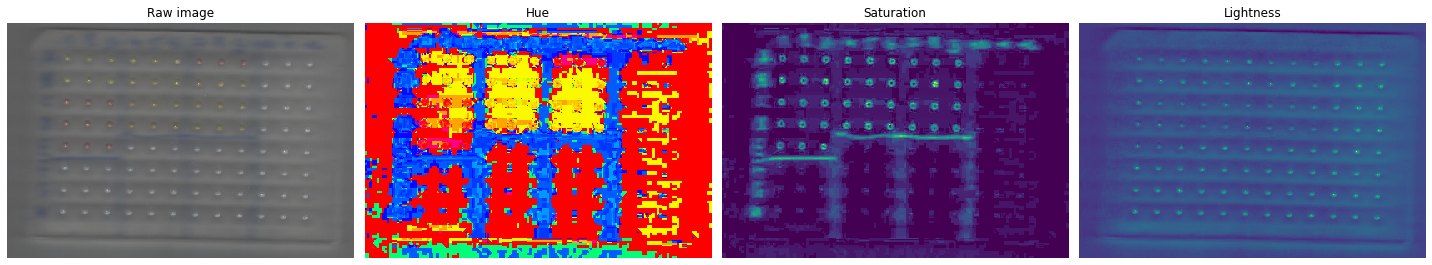

In [3]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(20, 10))
ax0.imshow(pic)
ax0.set_title('Raw image')
ax0.set_axis_off()
ax1.imshow(hsv_pic[:, :, 0], cmap='hsv')
ax1.set_title('Hue')
ax1.set_axis_off()
ax2.imshow(hsv_pic[:, :, 1])
ax2.set_title('Saturation')
ax2.set_axis_off()
ax3.imshow(hsv_pic[:, :, 2])
ax3.set_title('Lightness')
ax3.set_axis_off()
plt.tight_layout()

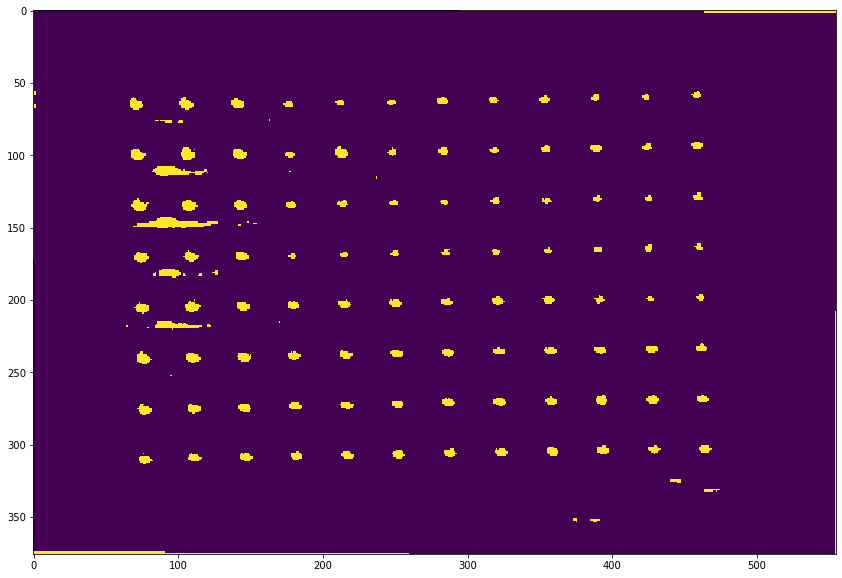

In [110]:
#Value
plt.figure(figsize=(15,10))
val = hsv_pic[:, :, 2].copy()

threshold= 0.47
mask = val>threshold


plt.imshow(mask)

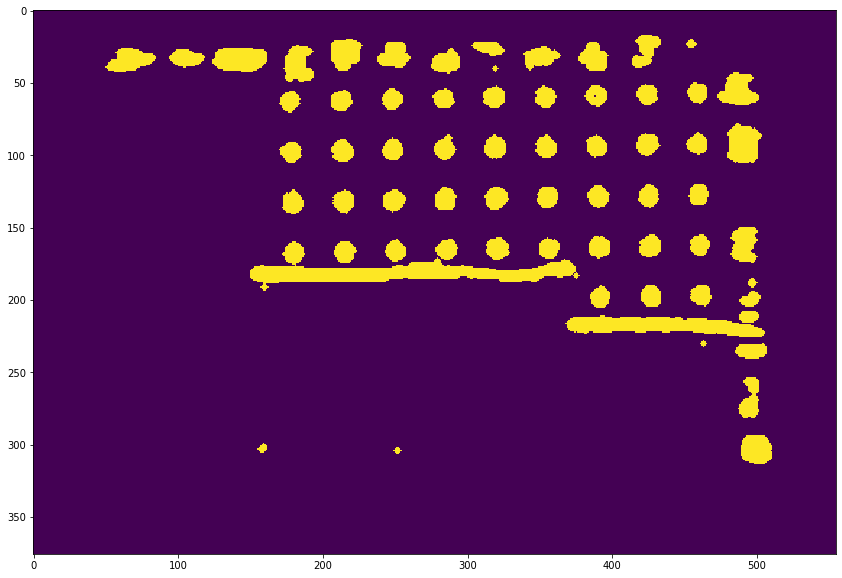

In [147]:
plt.figure(figsize=(15,10))
saturation = hsv_pic[:, :, 1].copy()
threshold_s= 0.1
mask_sat = saturation>threshold_s
mask_sat = binary_dilation(mask_sat, iterations=3)

plt.imshow(mask_sat)

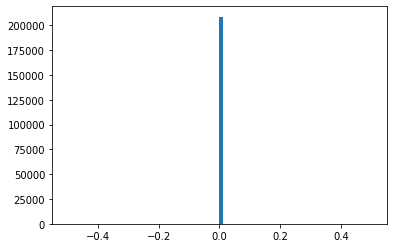

In [136]:
plt.figure()
plt.hist(mask_sat.astype(int).ravel(), bins=100);

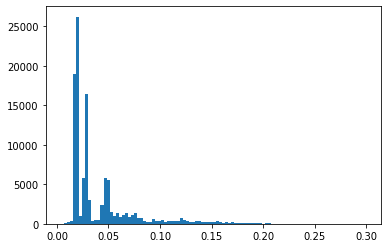

In [130]:
plt.figure()
plt.hist(saturation[saturation>0.001].ravel(), bins=100);

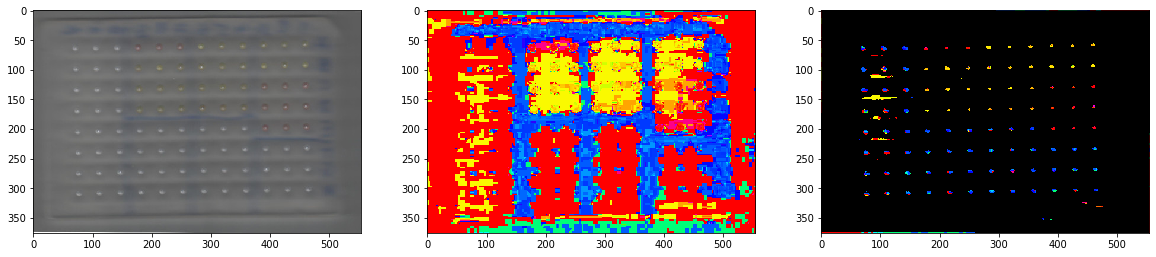

In [94]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20, 10))
ax0.imshow(pic)
ax1.imshow(hsv_pic[:, :, 0], cmap='hsv')

#masked image
result  = hsv_pic[:, :, 0].copy()

result_masked = np.ma.masked_where(mask==False, result)

#result[mask == False] = 0

cmap = plt.cm.hsv
cmap.set_bad(color='black')

ax2.imshow(result_masked, cmap=cmap)

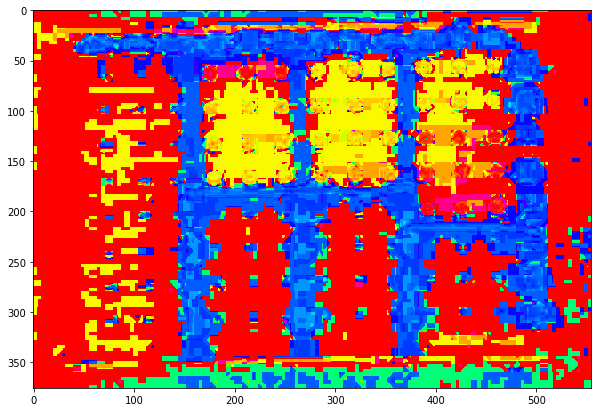

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(hsv_pic[:,:,0], cmap='hsv')

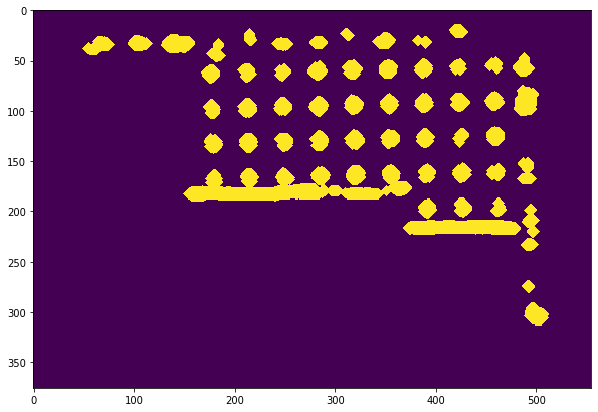

In [54]:
#Find the threshold for the saturation
plt.figure(figsize=(10,10))

saturation = hsv_pic[:, :, 1].copy()
threshold_s= 0.14
mask_sat = saturation>threshold_s
mask_sat = binary_dilation(mask_sat, iterations=5)
plt.imshow(mask_sat)

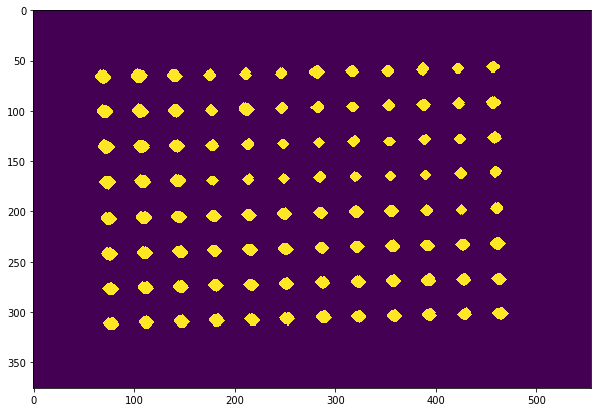

In [53]:
#Find the threshold for the lightness
plt.figure(figsize=(10,10))

val = hsv_pic[:, :, 2].copy()
threshold_v= 0.50
mask_val = val>threshold_v
mask_val = binary_dilation(mask_val, iterations=4)

plt.imshow(mask_val)

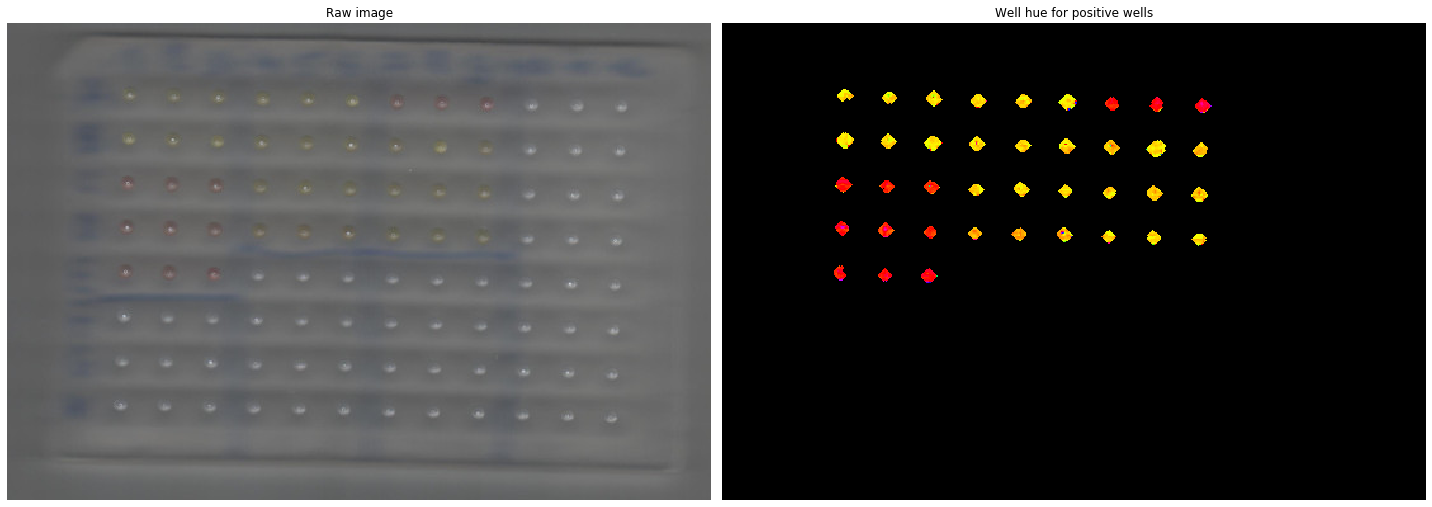

In [4]:
#pic = io.imread('Scanned Document.jpg')

#Convert to hsv
#hsv_pic = rgb2hsv(pic)

#Use values to make a mask for the wells
val = hsv_pic[:, :, 2].copy()
threshold_v= 0.50
mask_val = val>threshold_v
mask_val = binary_dilation(mask_val, iterations=4)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10))
ax0.imshow(pic)
ax0.set_axis_off()
ax0.set_title('Raw image')


#Use the saturation to maks wells with samples
saturation = hsv_pic[:, :, 1].copy()
threshold_s= 0.14
mask_sat = saturation>threshold_s
mask_sat = binary_dilation(mask_sat, iterations=4)

#Combine masks
mask = np.logical_and(mask_val, mask_sat)

#masked image
result  = hsv_pic[:, :, 0].copy()
result_masked = np.ma.masked_where(mask==False, result)
cmap = plt.cm.hsv
cmap.set_bad(color='black')

ax1.imshow(result_masked, cmap=cmap)
ax1.set_axis_off()
ax1.set_title('Well hue for positive wells')

plt.tight_layout()
#plt.savefig('LAMP_color_detection_by_scanner.png', dpi=300)

In [6]:
labels, nobjects = ndimage.label(mask_val.astype(int))
#slices = ndimage.find_objects(labels)

centers = np.array(ndimage.center_of_mass(mask_val.astype(int), labels=labels, index=np.unique(labels)[1:]))

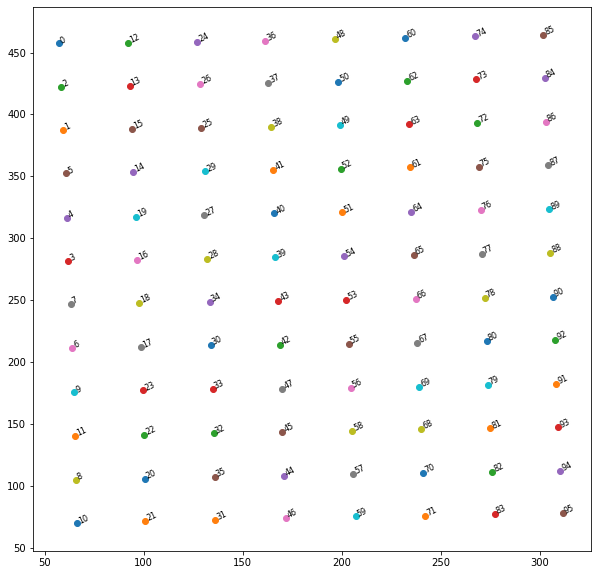

In [210]:
centers = np.array(ndimage.center_of_mass(mask_val.astype(int), labels=labels, index=np.unique(labels)[1:]))

plt.figure(figsize=(10,10))
#centers= np.sort(centers,)
for n,(x,y) in enumerate(zip(centers[:,0], centers[:,1])):
    plt.scatter(x,y, )
    plt.gca().annotate(n, (x+0.05, y), rotation=25, fontsize=8)

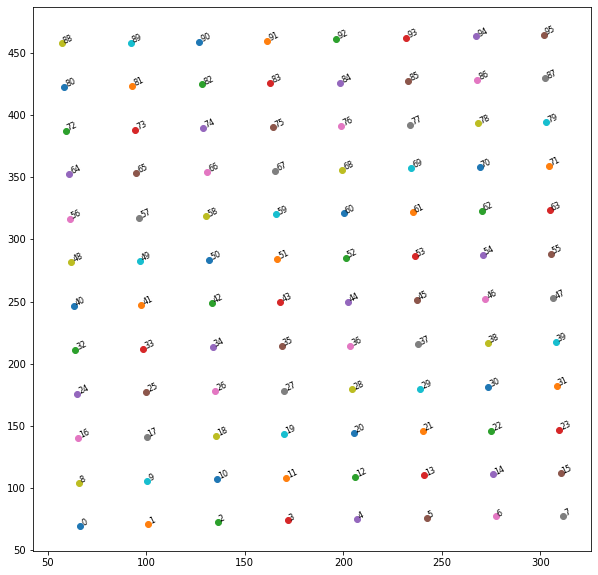

In [224]:
centers = np.array(ndimage.center_of_mass(mask_val.astype(int), labels=labels, index=np.unique(labels)[1:]))

plt.figure(figsize=(10,10))
sort = np.lexsort((centers[:,0], centers[:,1]))

for n,s in enumerate(sort):
    coi = centers[s]
    x = coi[0]
    y = coi[1]
    plt.scatter(x,y )
    plt.gca().annotate(n, (x+0.05, y), rotation=25, fontsize=8)

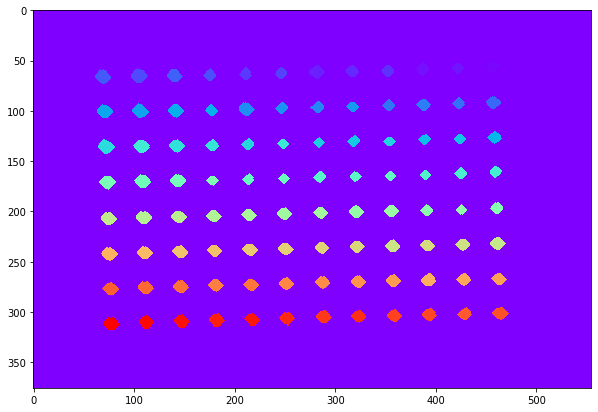

In [123]:
plt.figure(figsize=(10,10))
plt.imshow(labels, cmap='rainbow')

Text(0.5, 1.0, 'Median hue of well')

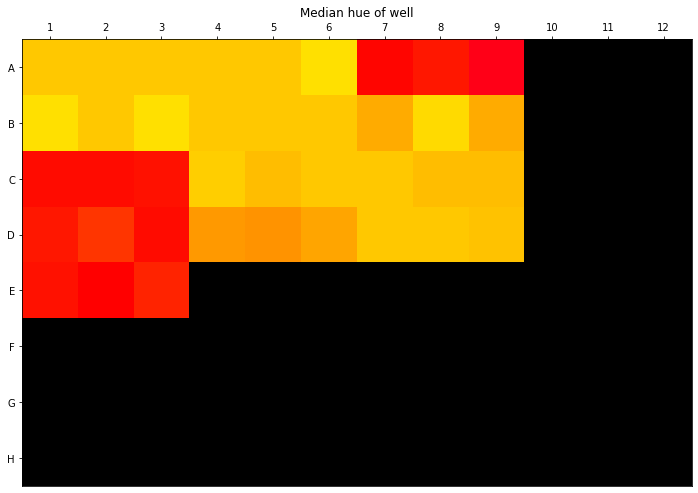

In [27]:
average_result = np.zeros(nobjects)
filled = np.ma.filled(result_masked, np.nan)

sort = np.lexsort((centers[:,1], centers[:,0]))
label_order = np.unique(labels)[1:]

for n, s in enumerate(sort):
    values = filled[labels == label_order[s]]
    values = values[np.isfinite(values)]
    if values.size > 0:
        average_result[n] = np.median(values)
    else:
        average_result[n] = np.nan
        
plt.figure(figsize=(12,10))
plt.imshow(average_result.reshape((8,12)), cmap='hsv')
plt.yticks(np.arange(0, 8, 1),labels=[i for i in 'ABCDEFGH'])
plt.ylim(7.5,-0.5)
plt.xticks(np.arange(0, 12, 1),labels=np.arange(1, 13, 1))
plt.gca().xaxis.tick_top()
plt.title('Median hue of well')